In [24]:
import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt

In [25]:
# Relative Strength Index
# The relative strength index (RSI) is a momentum indicator that 
# measures the magnitude of recent price changes to evaluate overbought 
# or oversold conditions in the price of a stock or other asset.
# Signals are considered overbought when the indicator is above 70% 
# and oversold when the indicator is below 30%.
def rsi(values):
    up = values[values>0].mean()
    down = -1*values[values<0].mean()
    return 100 * up / (up + down)

def lowpassfilter(signal, thresh = 0.01, wavelet='haar', level = 1):
    coeff = pywt.wavedec(signal, wavelet, mode="per",level=level)
    thresh = thresh*np.nanmax(coeff[1])
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per")
    return pd.DataFrame(reconstructed_signal)

In [26]:
df = pd.read_pickle("/home/filip/Desktop/Ruđer/FinalData/distinct.pkl").reset_index(drop=True)
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors='coerce')
df.head()

,Median_exchanges,Std_exchanges,Price_exchanges,High_exchanges,Low_exchanges,Timestamp,High_trades,Low_trades,Trades_trades,Std_trades,...,Var_trades,High,Low,Trades,Std,Price,Open,Close,Volume,Volume_mean
0,238.001667,1.808013,238.455022,241.900000,237.005000,2015-02-03 00:02:00,241.9,237.00,67.0,0.605145,...,0.366200,237.01,237.00,2.0,0.007071,237.005000,237.01,237.00,0.519,0.25950
1,237.682330,2.353496,238.608165,242.100000,236.968000,2015-02-03 00:03:00,242.1,236.85,55.0,0.709264,...,0.503056,236.99,236.94,5.0,0.017889,236.968000,236.94,236.97,8.398,1.67960
2,237.834016,1.629791,238.136033,241.840000,236.610000,2015-02-03 00:04:00,241.9,236.61,52.0,1.325131,...,1.755972,236.97,236.97,4.0,0.000000,236.970000,236.97,236.97,4.351,1.08775
3,237.176000,2.035995,238.110779,241.700000,236.910000,2015-02-03 00:05:00,241.7,236.51,31.0,0.869286,...,0.755658,236.94,236.90,5.0,0.017321,236.910000,236.91,236.94,3.713,0.74260
4,238.152260,1.542811,238.505027,241.733333,236.913333,2015-02-03 00:06:00,241.8,236.90,47.0,0.996311,...,0.992636,236.94,236.90,3.0,0.023094,236.913333,236.90,236.94,12.000,4.00000


In [27]:
def create_column_features(df, column, thresh):
    df["Denoised_Price_1_"+column] = lowpassfilter(df[column],thresh)
    df["Denoised_Price_2_"+column] = lowpassfilter(df[column],level =2,thresh = thresh)
    df["Price_Change_"+column] = df[column].pct_change()
    df.loc[df["Price_Change_"+column]>10,"Price_Change_"+column]= 0
    df["Denoised_Price_Change_"+column] = df["Denoised_Price_1_"+column].pct_change()
    df.loc[df["Denoised_Price_Change_"+column]>10,"Denoised_Price_Change_"+column]= 0
    df.tail(100).plot(x="Timestamp",y=[column,"Denoised_Price_1_"+column,"Denoised_Price_2_"+column],figsize=(20,5))
    plt.show()
    df.tail(100).plot(x="Timestamp",y=["Price_Change_"+column,"Denoised_Price_Change_"+column],figsize=(20,5))
    return df

In [28]:
df['Momentum_1D'] = (df["Price"]-df["Price"].shift(1)).fillna(0)
df['RSI_14D'] = df['Momentum_1D'].rolling(center=False, window=14).apply(rsi).fillna(0)

/home/filip/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  
/home/filip/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice.
  if __name__ == '__main__':
/home/filip/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  


In [29]:
df.head()

,Median_exchanges,Std_exchanges,Price_exchanges,High_exchanges,Low_exchanges,Timestamp,High_trades,Low_trades,Trades_trades,Std_trades,...,Low,Trades,Std,Price,Open,Close,Volume,Volume_mean,Momentum_1D,RSI_14D
0,238.001667,1.808013,238.455022,241.900000,237.005000,2015-02-03 00:02:00,241.9,237.00,67.0,0.605145,...,237.00,2.0,0.007071,237.005000,237.01,237.00,0.519,0.25950,0.000000,0.0
1,237.682330,2.353496,238.608165,242.100000,236.968000,2015-02-03 00:03:00,242.1,236.85,55.0,0.709264,...,236.94,5.0,0.017889,236.968000,236.94,236.97,8.398,1.67960,-0.037000,0.0
2,237.834016,1.629791,238.136033,241.840000,236.610000,2015-02-03 00:04:00,241.9,236.61,52.0,1.325131,...,236.97,4.0,0.000000,236.970000,236.97,236.97,4.351,1.08775,0.002000,0.0
3,237.176000,2.035995,238.110779,241.700000,236.910000,2015-02-03 00:05:00,241.7,236.51,31.0,0.869286,...,236.90,5.0,0.017321,236.910000,236.91,236.94,3.713,0.74260,-0.060000,0.0
4,238.152260,1.542811,238.505027,241.733333,236.913333,2015-02-03 00:06:00,241.8,236.90,47.0,0.996311,...,236.90,3.0,0.023094,236.913333,236.90,236.94,12.000,4.00000,0.003333,0.0


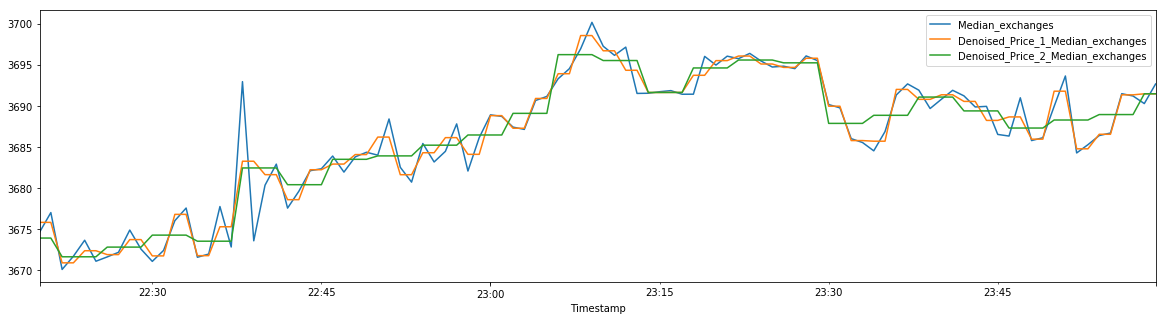

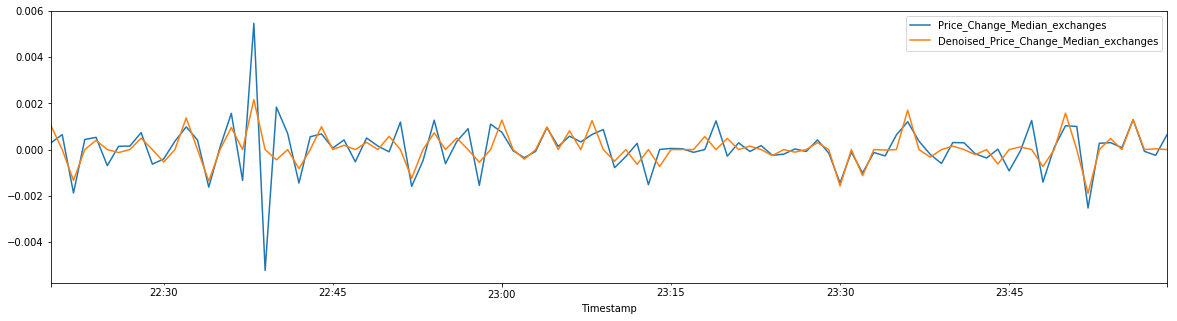

In [30]:
df = create_column_features(df, "Median_exchanges",0.05)

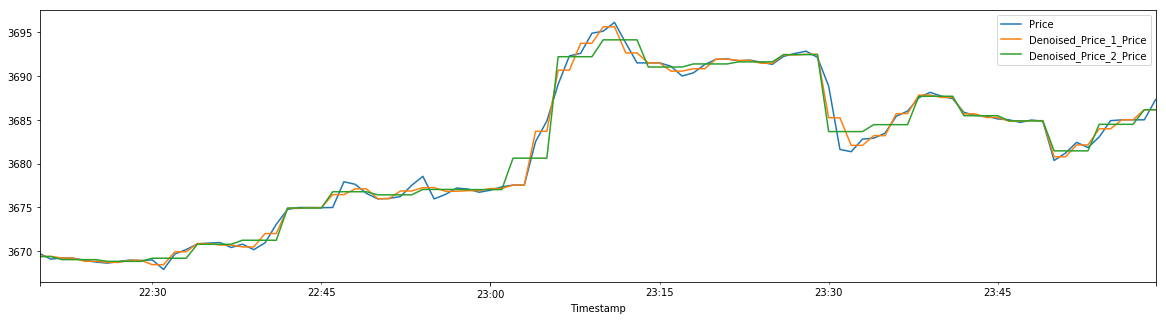

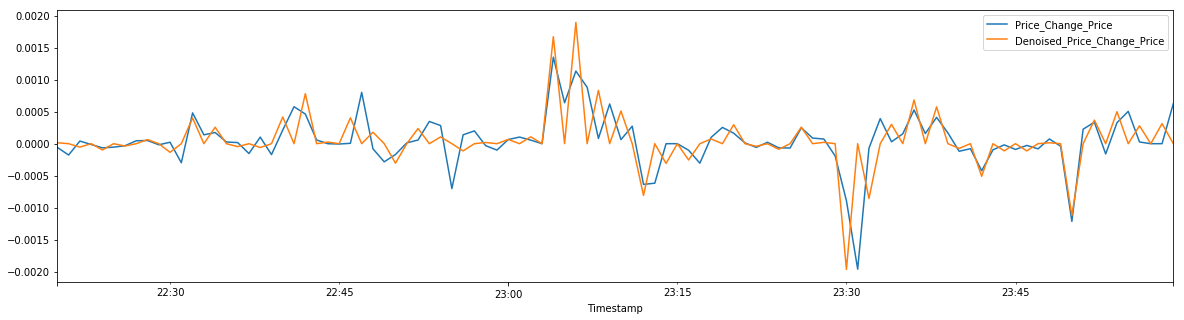

In [31]:
df = create_column_features(df, "Price",0.05)

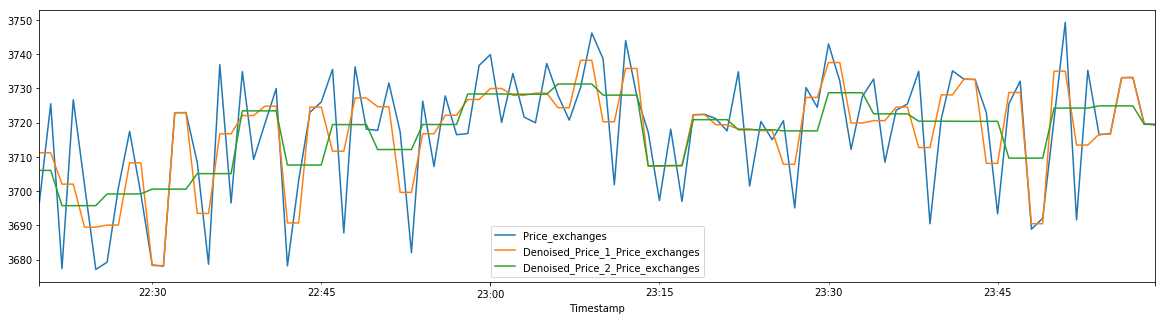

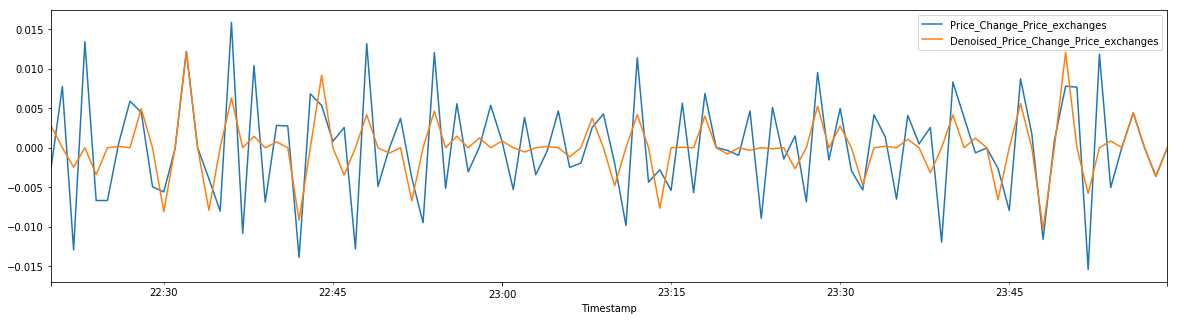

In [32]:
df = create_column_features(df, "Price_exchanges",0.05)

In [ ]:
for name in distinct.columns:
    if name!="Timestamp":
        print(name)
        distinct.plot(x="Timestamp",y=name)
        plt.show()

In [33]:
df = df.dropna()
df.to_pickle("/home/filip/Desktop/Ruđer/FinalData/distinct_features.pkl")